In [1]:
import pandas as pd
import numpy as np
import pmdarima as pm
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from prophet import Prophet
from itertools import product
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
import warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
np.random.seed(42)
sns.set()

C:\Users\blake\anaconda3\envs\capstone2_venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\blake\anaconda3\envs\capstone2_venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
Importing plotly failed. Interactive plots will not work.


In [2]:
df = pd.read_csv(r"C:\Users\blake\Documents\Springboard\Github\Capstone2\Covid_Final\Capstone_2_Covid_TimeSeries\data\modeling\may_CA_only_modeling_data.csv", index_col='date', parse_dates=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 840 entries, 2020-01-25 to 2022-05-13
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   state          840 non-null    object 
 1   cases          840 non-null    int64  
 2   deaths         840 non-null    float64
 3   new_cases      840 non-null    float64
 4   pct_change     839 non-null    float64
 5   seven_day_ave  840 non-null    float64
 6   split          840 non-null    object 
dtypes: float64(4), int64(1), object(2)
memory usage: 52.5+ KB


### Define functions for later use

In [3]:
# Function to plot predictons agains ture values
def plot_predictions(true, pred, c1='r', c2='b'):
    pred.plot(c=c1, legend=True)
    true.plot(c=c2, legend=True)
    

## Basic ARIMAX model

In EDA I found that differencing of 1 was sufficient for covid data and 1 was sufficient for hospital data. Examine the ACF and PACF for both data sets to determine appropriate AR and MA parameters

adfuller p-value: 5.527936826825075e-10


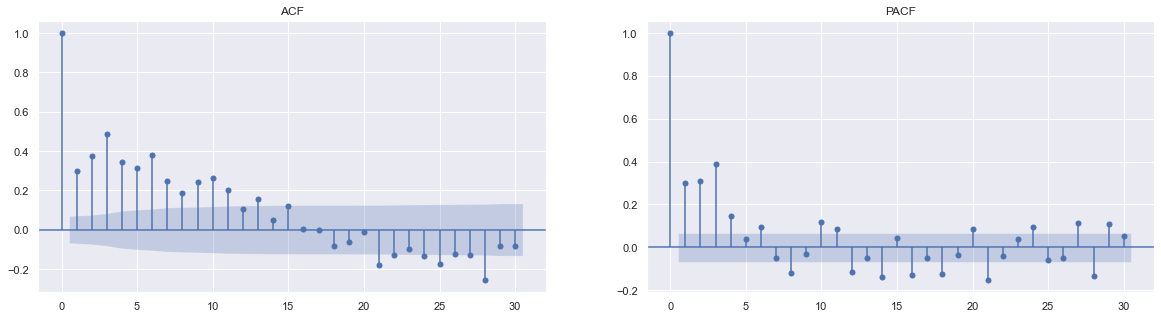

In [4]:
fig, ax = plt.subplots(1,2, figsize=(20,5))

plot_acf(df.loc[df.split=='train', 'seven_day_ave'].diff().dropna(), ax=ax[0])
ax[0].set_title('ACF')

plot_pacf(df.loc[df.split=='train', 'seven_day_ave'].diff().dropna(), ax=ax[1])
ax[1].set_title('PACF')

dicky_fuller = adfuller(df.loc[df.split=='train', 'seven_day_ave'].diff().dropna())
print("adfuller p-value:", dicky_fuller[1])

Based on the ACF and PACF plots it looks like the AR term should be 3 and the MA term should be 6

In [5]:
endog = df.loc[df.split=='train', 'seven_day_ave']

sarimax = SARIMAX(endog, order=(3,1,6))
results = sarimax.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:          seven_day_ave   No. Observations:                  810
Model:               SARIMAX(3, 1, 6)   Log Likelihood               -7024.899
Date:                Fri, 20 May 2022   AIC                          14069.799
Time:                        12:48:10   BIC                          14116.757
Sample:                    01-25-2020   HQIC                         14087.828
                         - 04-13-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3569      0.024     14.658      0.000       0.309       0.405
ar.L2         -0.4958      0.018    -28.187      0.000      -0.530      -0.461
ar.L3          0.7945      0.022     35.590      0.0

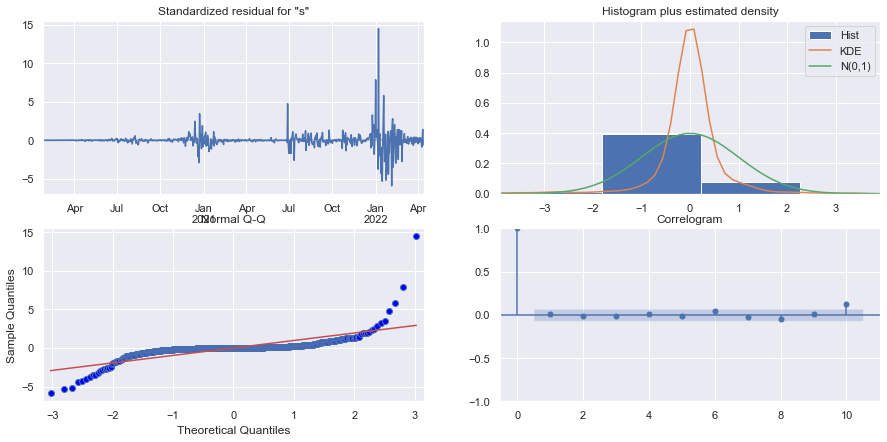

In [6]:
results.plot_diagnostics(figsize=(15,7));

The hope for an ARIMA model is that the residuals will resemble white noise, meaning they are uncorrelatd and normaly distributed. While the residuals do appear to be uncorrelated, the histogram and Normal Q-Q plots indicate that they are not normaly distributed, this is further backed up by the Prob(JB) value of 0.0. 

In [7]:
pred = results.predict()
print("MAPE:", mean_absolute_percentage_error(endog, pred))
print("R-Squared:", r2_score(endog, pred))

MAPE: 3476428868015.553
R-Squared: 0.9946462835968096


In [8]:
# Forecast the test set
forecast = results.forecast(steps='2022-05-13')

print("Validation MAPE:", mean_absolute_percentage_error(df.loc[df.split=='test', 'seven_day_ave'], forecast))
print('Validation R-Squared:', r2_score(df.loc[df.split=='test', 'seven_day_ave'], forecast))
print('Validation MRSE:', np.sqrt(mean_squared_error(df.loc[df.split=='test', 'seven_day_ave'], forecast)))

Validation MAPE: 0.2964246788722848
Validation R-Squared: -0.9433307792194703
Validation MRSE: 3135.6584500024273


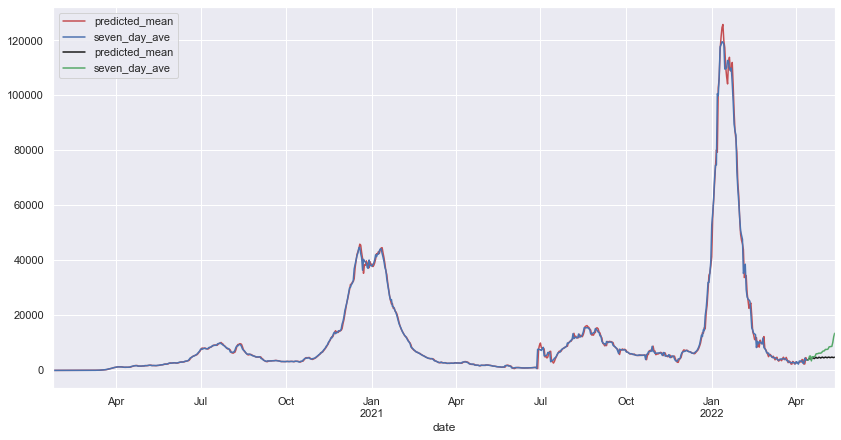

In [9]:
plt.figure(figsize=(14,7))
plot_predictions(endog, pred)
plot_predictions(df.loc[df.split=='test', 'seven_day_ave'], forecast, c1='k', c2='g')
plt.show()

The metrics for this model are not great, the model does a fine job predicting in sample values but struggles with the testing data. This indicates that the model may be overfitting. It's not surprising that this model isn't performing too well since it's hyper parameters where determined by eyeballing the ACF and PACF plots.

## Use Auto ARIMA for hyper parameter tuning

Next I will be using an auto ARIMA model to do better tune the hyper parameters for the model.

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=18302.597, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=18535.399, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=14366.012, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=14158.283, Time=0.61 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=14128.953, Time=0.65 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=14256.397, Time=0.20 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=14095.466, Time=0.33 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=14120.355, Time=0.23 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=14097.981, Time=0.57 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=14098.399, Time=0.42 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=14111.525, Time=0.72 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   :

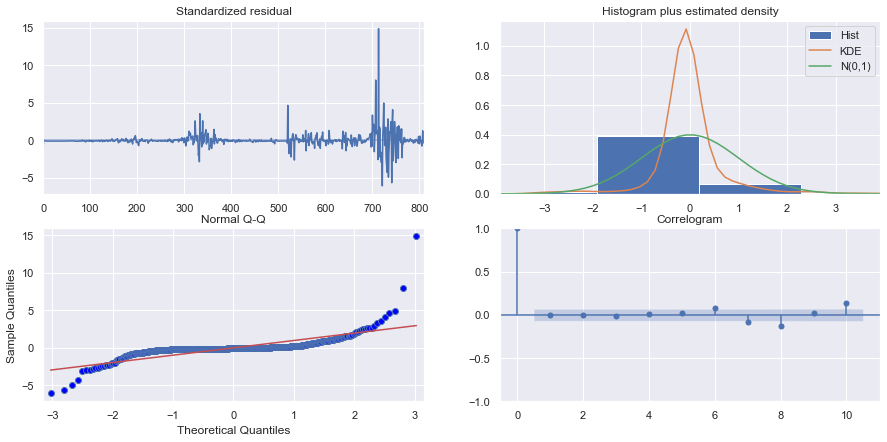

In [10]:
model = pm.auto_arima(endog, start_p=0, start_q=0, test='adf',
        max_p=10, max_q=14, seasonal=True, trace=True,
        suppress_warnings=True)

model.plot_diagnostics(figsize=(15,7));

In [11]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  810
Model:               SARIMAX(4, 0, 1)   Log Likelihood               -7040.733
Date:                Fri, 20 May 2022   AIC                          14095.466
Time:                        12:48:48   BIC                          14128.345
Sample:                             0   HQIC                         14108.089
                                - 810                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    113.1027     58.451      1.935      0.053      -1.459     227.665
ar.L1          1.4298      0.031     46.287      0.000       1.369       1.490
ar.L2         -0.2782      0.043     -6.427      0.000      -0.363      -0.193
ar.L3          0.1262      0.033      3.841      0.000       0.062       0.191
ar.L4         -0.2860      0.021    -13.751      0.000      -0.327      -0.245
ma.L1         -0.4380      0.033    -13.093      0.000      -0.504      -0.372
sigma2      2.144e+06      0.044    4.9e+07      0.000    2.14e+06    2.14e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            201097.32
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):              91.00   Skew:                             4.62
Prob(H) (two-sided):                  0.00   Kurtosis:                        79.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.97e+21. Standard errors may be unstable.
"""

This model seems to have a similar issue to the first one, the residuals do not appear to be normaly distributed.

In [12]:
pred = pd.Series(model.predict_in_sample(), index=df.loc[df.split=='train'].index)

In [13]:
forecast = model.predict(n_periods=df.loc[df.split=='test'].shape[0]) 
print('Validation MAPE:', mean_absolute_percentage_error(df.loc[df.split=='test', 'seven_day_ave'], forecast))
print('Validation R-Squared:', r2_score(df.loc[df.split=='test', 'seven_day_ave'], forecast))
print('Validation MRSE:', np.sqrt(mean_squared_error(df.loc[df.split=='test', 'seven_day_ave'], forecast)))

Validation MAPE: 0.3673097155461581
Validation R-Squared: -0.6460112074240765
Validation MRSE: 2885.8368891518166


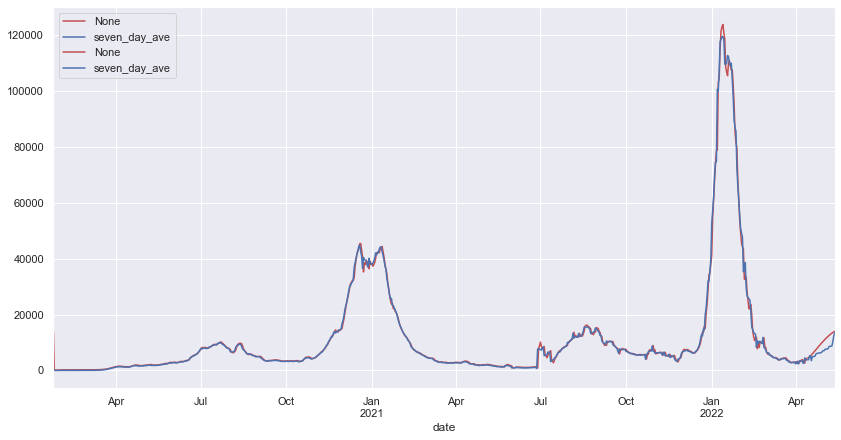

In [14]:
forecast = pd.Series(forecast, index=df.loc[df.split=='test'].index)

plt.figure(figsize=(14,7))
plot_predictions(df.loc[df.split=='test', 'seven_day_ave'], forecast)
plot_predictions(endog, pred)
plt.show()

This model seems to preform slightly better than the initial one. In terms of test predictions the upward trend is being captured, but the actual predicted values are still pretty far off the mark.

## Try LSTM neural network

The final model will be an LSTM neural network. For this model I will define a function generates and scores a model with a given set of parameters. This function can then be run through a loop to perform a grid search.

In [15]:
# Create lists of parameters
time_steps = [2, 4, 8, 10]
nodes = [4, 7, 10]
dropout_rate = [0.05, 0.1, .15]
validation_split= [0.1]
batch = [32, 64]
epochs = [15]

# Use itertools.product() to generate all possible combinations of parameters
param_list = list(product(time_steps, nodes, dropout_rate, validation_split, batch, epochs))

In [16]:
# Prep data for model
train_X, train_y = df.loc[df.split=='train', 'seven_day_ave'], df.loc[df.split=='train', 'seven_day_ave']
test_X, test_y = df.loc[df.split=='test', 'seven_day_ave'], df.loc[df.split=='test', 'seven_day_ave']

train_X = train_X.to_frame()
test_X = test_X.to_frame()
train_y = train_y.to_frame()
test_y = test_y.to_frame()

In [17]:
# Now created a function that takes train/test data and tuple of params to create and score a model
def model_(params, train_X, test_X, train_y, test_y):
    
    '''
    This function will do end to end model creation with given test/train data and a list of parameters.
    The function will scale and shape data, run it through a two layer LSTM model, then score the data and 
    return the model, data scaler, parameters, and metrics.
    '''
    
    # Set random seed for consistent results
    np.random.seed(42)
    tensorflow.random.set_seed(42)
    
    
    # Scale Data
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    scaler_X.fit(train_X)
    scaler_y.fit(train_y)

    scaled_train_X = scaler_X.transform(train_X)
    scaled_test_X = scaler_X.transform(test_X)
    scaled_train_y = scaler_y.transform(train_y)
    scaled_test_y = scaler_y.transform(test_y)
    
    
    # Get parameters for the model
    steps = params[0]
    nodes = params[1]
    dropout = params[2]
    validation = params[3]
    batch = params[4]
    epoch = params[5]
    
    
    # shape data for training
    X_train = []
    y_train = []
    
    for i in range(steps, scaled_train_X.shape[0]):
        xi = scaled_train_X[i-steps:i]
        yi = scaled_train_y[i]
        
        X_train.append(xi)
        y_train.append(yi)
    
    X_train, y_train = np.array(X_train), np.array(y_train)
    
    
    # Create model
    model = Sequential()
    
    # Add layers
    model.add(LSTM(units=nodes, return_sequences=True, input_shape=(X_train.shape[1],1)))
    model.add(Dropout(dropout))
    
    model.add(LSTM(units=nodes, return_sequences=False, input_shape=(X_train.shape[1],1)))
    model.add(Dropout(dropout))
    
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mse')
    
    
    # Fit model
    model.fit(X_train, y_train, batch_size=batch, validation_split=validation, epochs=epoch, shuffle=False)
    
    # Record training history
    history = model.history.history
    
    # Shape data for testing
    scaled_test_X = np.append(scaled_train_X[-steps:], scaled_test_X, axis=0)
    X_test = []
    
    for i in range(steps, scaled_test_X.shape[0]):
        xi = scaled_test_X[i-steps:i]
        X_test.append(xi)
    
    X_test = np.array(X_test)
    
    
    # Generate test forecast
    fore = model.predict(X_test)
    
    # Generate train predictions
    pred = model.predict(X_train)
    
    # Unscale predictions
    forecast = scaler_y.inverse_transform(fore)
    
    
    # Generate pefromance metrics and returnt them along with r2
    mape = mean_absolute_percentage_error(test_y, forecast)

    
    return params, mape, model, history, fore, pred, scaler_y
    

Run the LSTM function through a loop of parameter combinations and store the results in a data frame. Then sort the data frame based on metrics.

In [62]:
model_results = []

for i in param_list:
    p, mape, model, history, fore, pred, scaler = model_(i, train_X, test_X, train_y, test_y)
    
    model_results.append({
        'parameters':p,
        'MAPE':mape,
        'model':model,
        'history':history,
        'pred':pred,
        'forecast':fore,
        'scaler':scaler})

Epoch 1/15
23/23 [==============================] - 4s 33ms/step - loss: 0.0250 - val_loss: 0.0492
Epoch 2/15
23/23 [==============================] - 0s 3ms/step - loss: 0.0219 - val_loss: 0.0447
Epoch 3/15
23/23 [==============================] - 0s 3ms/step - loss: 0.0209 - val_loss: 0.0417
Epoch 4/15
23/23 [==============================] - 0s 3ms/step - loss: 0.0202 - val_loss: 0.0397
Epoch 5/15
23/23 [==============================] - 0s 3ms/step - loss: 0.0202 - val_loss: 0.0383
Epoch 6/15
23/23 [==============================] - 0s 3ms/step - loss: 0.0199 - val_loss: 0.0371
Epoch 7/15
23/23 [==============================] - 0s 3ms/step - loss: 0.0193 - val_loss: 0.0361
Epoch 8/15
23/23 [==============================] - 0s 2ms/step - loss: 0.0189 - val_loss: 0.0352
Epoch 9/15
23/23 [==============================] - 0s 3ms/step - loss: 0.0186 - val_loss: 0.0342
Epoch 10/15
23/23 [==============================] - 0s 3ms/step - loss: 0.0185 - val_loss: 0.0333
Epoch 11/15
23/23 

12/12 [==============================] - 0s 4ms/step - loss: 0.0293 - val_loss: 0.0617
Epoch 3/15
12/12 [==============================] - 0s 3ms/step - loss: 0.0275 - val_loss: 0.0583
Epoch 4/15
12/12 [==============================] - 0s 4ms/step - loss: 0.0266 - val_loss: 0.0555
Epoch 5/15
12/12 [==============================] - 0s 4ms/step - loss: 0.0255 - val_loss: 0.0533
Epoch 6/15
12/12 [==============================] - 0s 4ms/step - loss: 0.0248 - val_loss: 0.0513
Epoch 7/15
12/12 [==============================] - 0s 4ms/step - loss: 0.0244 - val_loss: 0.0496
Epoch 8/15
12/12 [==============================] - 0s 4ms/step - loss: 0.0242 - val_loss: 0.0482
Epoch 9/15
12/12 [==============================] - 0s 3ms/step - loss: 0.0243 - val_loss: 0.0469
Epoch 10/15
12/12 [==============================] - 0s 4ms/step - loss: 0.0239 - val_loss: 0.0458
Epoch 11/15
12/12 [==============================] - 0s 3ms/step - loss: 0.0241 - val_loss: 0.0448
Epoch 12/15
12/12 [==========

23/23 [==============================] - 0s 3ms/step - loss: 0.0165 - val_loss: 0.0293
Epoch 4/15
23/23 [==============================] - 0s 3ms/step - loss: 0.0160 - val_loss: 0.0272
Epoch 5/15
23/23 [==============================] - 0s 3ms/step - loss: 0.0174 - val_loss: 0.0255
Epoch 6/15
23/23 [==============================] - 0s 3ms/step - loss: 0.0160 - val_loss: 0.0239
Epoch 7/15
23/23 [==============================] - 0s 3ms/step - loss: 0.0150 - val_loss: 0.0223
Epoch 8/15
23/23 [==============================] - 0s 4ms/step - loss: 0.0137 - val_loss: 0.0206
Epoch 9/15
23/23 [==============================] - 0s 3ms/step - loss: 0.0137 - val_loss: 0.0187
Epoch 10/15
23/23 [==============================] - 0s 3ms/step - loss: 0.0115 - val_loss: 0.0168
Epoch 11/15
23/23 [==============================] - 0s 3ms/step - loss: 0.0122 - val_loss: 0.0148
Epoch 12/15
23/23 [==============================] - 0s 3ms/step - loss: 0.0108 - val_loss: 0.0130
Epoch 13/15
23/23 [=========

12/12 [==============================] - 0s 5ms/step - loss: 0.0215 - val_loss: 0.0404
Epoch 5/15
12/12 [==============================] - 0s 5ms/step - loss: 0.0215 - val_loss: 0.0374
Epoch 6/15
12/12 [==============================] - 0s 5ms/step - loss: 0.0211 - val_loss: 0.0349
Epoch 7/15
12/12 [==============================] - 0s 5ms/step - loss: 0.0209 - val_loss: 0.0327
Epoch 8/15
12/12 [==============================] - 0s 5ms/step - loss: 0.0201 - val_loss: 0.0306
Epoch 9/15
12/12 [==============================] - 0s 5ms/step - loss: 0.0192 - val_loss: 0.0285
Epoch 10/15
12/12 [==============================] - 0s 5ms/step - loss: 0.0190 - val_loss: 0.0264
Epoch 11/15
12/12 [==============================] - 0s 5ms/step - loss: 0.0179 - val_loss: 0.0242
Epoch 12/15
12/12 [==============================] - 0s 5ms/step - loss: 0.0166 - val_loss: 0.0219
Epoch 13/15
12/12 [==============================] - 0s 5ms/step - loss: 0.0160 - val_loss: 0.0195
Epoch 14/15
12/12 [========

23/23 [==============================] - 0s 6ms/step - loss: 0.0202 - val_loss: 0.0316
Epoch 6/15
23/23 [==============================] - 0s 6ms/step - loss: 0.0186 - val_loss: 0.0272
Epoch 7/15
23/23 [==============================] - 0s 6ms/step - loss: 0.0167 - val_loss: 0.0223
Epoch 8/15
23/23 [==============================] - 0s 6ms/step - loss: 0.0159 - val_loss: 0.0174
Epoch 9/15
23/23 [==============================] - 0s 6ms/step - loss: 0.0126 - val_loss: 0.0125
Epoch 10/15
23/23 [==============================] - 0s 6ms/step - loss: 0.0102 - val_loss: 0.0082
Epoch 11/15
23/23 [==============================] - 0s 6ms/step - loss: 0.0081 - val_loss: 0.0050
Epoch 12/15
23/23 [==============================] - 0s 6ms/step - loss: 0.0058 - val_loss: 0.0038
Epoch 13/15
23/23 [==============================] - 0s 6ms/step - loss: 0.0038 - val_loss: 0.0051
Epoch 14/15
23/23 [==============================] - 0s 6ms/step - loss: 0.0040 - val_loss: 0.0083
Epoch 15/15
23/23 [=======

12/12 [==============================] - 0s 8ms/step - loss: 0.0121 - val_loss: 0.0089
Epoch 7/15
12/12 [==============================] - 0s 7ms/step - loss: 0.0114 - val_loss: 0.0079
Epoch 8/15
12/12 [==============================] - 0s 8ms/step - loss: 0.0114 - val_loss: 0.0070
Epoch 9/15
12/12 [==============================] - 0s 8ms/step - loss: 0.0105 - val_loss: 0.0061
Epoch 10/15
12/12 [==============================] - 0s 8ms/step - loss: 0.0091 - val_loss: 0.0054
Epoch 11/15
12/12 [==============================] - 0s 7ms/step - loss: 0.0079 - val_loss: 0.0049
Epoch 12/15
12/12 [==============================] - 0s 8ms/step - loss: 0.0071 - val_loss: 0.0046
Epoch 13/15
12/12 [==============================] - 0s 8ms/step - loss: 0.0075 - val_loss: 0.0047
Epoch 14/15
12/12 [==============================] - 0s 8ms/step - loss: 0.0067 - val_loss: 0.0051
Epoch 15/15
12/12 [==============================] - 0s 8ms/step - loss: 0.0052 - val_loss: 0.0058
Epoch 1/15
23/23 [=======

23/23 [==============================] - 0s 7ms/step - loss: 0.0076 - val_loss: 0.0030
Epoch 8/15
23/23 [==============================] - 0s 7ms/step - loss: 0.0048 - val_loss: 0.0061
Epoch 9/15
23/23 [==============================] - 0s 7ms/step - loss: 0.0032 - val_loss: 0.0140
Epoch 10/15
23/23 [==============================] - 0s 7ms/step - loss: 0.0026 - val_loss: 0.0210
Epoch 11/15
23/23 [==============================] - 0s 7ms/step - loss: 0.0028 - val_loss: 0.0244
Epoch 12/15
23/23 [==============================] - 0s 7ms/step - loss: 0.0027 - val_loss: 0.0239
Epoch 13/15
23/23 [==============================] - 0s 7ms/step - loss: 0.0029 - val_loss: 0.0192
Epoch 14/15
23/23 [==============================] - 0s 7ms/step - loss: 0.0028 - val_loss: 0.0211
Epoch 15/15
23/23 [==============================] - 0s 7ms/step - loss: 0.0025 - val_loss: 0.0217
Epoch 1/15
12/12 [==============================] - 4s 80ms/step - loss: 0.0298 - val_loss: 0.0499
Epoch 2/15
12/12 [======

In [63]:
results_df = pd.DataFrame(model_results)
results_df.sort_values(by='MAPE', inplace=True)
results_df.head()

,parameters,MAPE,model,history,pred,forecast,scaler
36,"(8, 4, 0.05, 0.1, 32, 15)",0.088505,<keras.engine.sequential.Sequential object at ...,"{'loss': [0.016301807016134262, 0.013650245964...","[[0.013790608], [0.0137907015], [0.013790875],...","[[0.037456535], [0.037902426], [0.03838197], [...",MinMaxScaler()
38,"(8, 4, 0.1, 0.1, 32, 15)",0.095682,<keras.engine.sequential.Sequential object at ...,"{'loss': [0.016538189724087715, 0.013739087618...","[[0.0131220585], [0.013122149], [0.013122318],...","[[0.03634593], [0.036783744], [0.03725411], [0...",MinMaxScaler()
40,"(8, 4, 0.15, 0.1, 32, 15)",0.101177,<keras.engine.sequential.Sequential object at ...,"{'loss': [0.01665491983294487, 0.0140350274741...","[[0.01377593], [0.013776016], [0.013776182], [...","[[0.0363704], [0.036798175], [0.037256576], [0...",MinMaxScaler()
68,"(10, 10, 0.1, 0.1, 32, 15)",0.106385,<keras.engine.sequential.Sequential object at ...,"{'loss': [0.025408480316400528, 0.021515812724...","[[0.012508225], [0.012508245], [0.01250832], [...","[[0.0353627], [0.036518414], [0.03686121], [0....",MinMaxScaler()
42,"(8, 7, 0.05, 0.1, 32, 15)",0.121774,<keras.engine.sequential.Sequential object at ...,"{'loss': [0.02769455872476101, 0.0238092392683...","[[0.0088566765], [0.0088566635], [0.008856827]...","[[0.032932896], [0.033165574], [0.033521563], ...",MinMaxScaler()


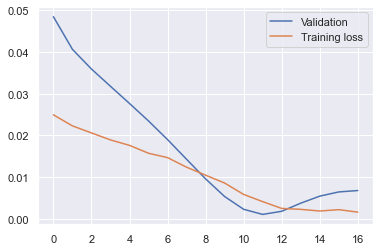

In [29]:
lstm = results_df.iloc[0,2]
loss = results_df.iloc[0,3]['loss']
val_loss = results_df.iloc[0,3]['val_loss']

plt.plot(val_loss, label='Validation')
plt.plot(loss, label='Training loss')
plt.legend()

Hyper parameters for best model = (8, 4, 0.05, 0.1, 32, 15)	

## Final Model

Now that the optimal hyperparameters have been determined, I'll create the final LSTM model.

In [18]:
time_steps = [8]
nodes = [4]
dropout_rate = [.05]
validation_split= [0.1]
batch = [32]
epochs = [15]

# Use itertools.product() to generate all possible combinations of parameters
param_list = list(product(time_steps, nodes, dropout_rate, validation_split, batch, epochs))

In [19]:
model_results = []

for i in param_list:
    p, mape, model, history, fore, pred, scaler = model_(i, train_X, test_X, train_y, test_y)
    
    model_results.append({
        'parameters':p,
        'MAPE':mape,
        'model':model,
        'history':history,
        'pred':pred,
        'forecast':fore,
        'scaler':scaler})

Epoch 1/15
23/23 [==============================] - 4s 34ms/step - loss: 0.0163 - val_loss: 0.0238
Epoch 2/15
23/23 [==============================] - 0s 5ms/step - loss: 0.0137 - val_loss: 0.0187
Epoch 3/15
23/23 [==============================] - 0s 5ms/step - loss: 0.0128 - val_loss: 0.0154
Epoch 4/15
23/23 [==============================] - 0s 5ms/step - loss: 0.0113 - val_loss: 0.0127
Epoch 5/15
23/23 [==============================] - 0s 5ms/step - loss: 0.0110 - val_loss: 0.0102
Epoch 6/15
23/23 [==============================] - 0s 5ms/step - loss: 0.0093 - val_loss: 0.0079
Epoch 7/15
23/23 [==============================] - 0s 5ms/step - loss: 0.0085 - val_loss: 0.0060
Epoch 8/15
23/23 [==============================] - 0s 5ms/step - loss: 0.0074 - val_loss: 0.0044
Epoch 9/15
23/23 [==============================] - 0s 5ms/step - loss: 0.0061 - val_loss: 0.0032
Epoch 10/15
23/23 [==============================] - 0s 5ms/step - loss: 0.0047 - val_loss: 0.0027
Epoch 11/15
23/23 

In [20]:
results_df = pd.DataFrame(model_results)
results_df.head()

,parameters,MAPE,model,history,pred,forecast,scaler
0,"(8, 4, 0.05, 0.1, 32, 15)",0.088505,<keras.engine.sequential.Sequential object at ...,"{'loss': [0.016301807016134262, 0.013650245964...","[[0.013790608], [0.0137907015], [0.013790875],...","[[0.037456535], [0.037902426], [0.03838197], [...",MinMaxScaler()


In [21]:
pred = results_df.iloc[0, 4]
fore = results_df.iloc[0, 5]

predictions = np.append(pred, fore, axis=0)

# Inverse scale the predicted data
lstm_scaler = results_df.iloc[0, 6]
predictions = lstm_scaler.inverse_transform(predictions)

predictions = predictions.reshape(predictions.shape[0])

In [22]:
# Since the LSTM uses a timestep of 8, the first 8 elements are not present in predicted data.
# Replace them with true values
predictions.shape, df.shape

((832,), (840, 7))

In [23]:
n = np.array(df.iloc[:8, 3])
predictions = np.append(n, predictions)

In [24]:
df['lstm_predictions'] = predictions

In [25]:
df.describe()

,cases,deaths,new_cases,pct_change,seven_day_ave,lstm_predictions
count,8.400000e+02,840.000000,840.000000,839.000000,840.000000,840.000000
mean,3.345382e+06,43970.794048,11132.892857,0.021531,11132.376369,11764.051360
std,2.882682e+06,31484.949465,22467.353795,0.081515,19149.900160,18125.123440
min,1.000000e+00,0.000000,-1607.000000,-0.000421,0.000000,0.000000
25%,6.639915e+05,12098.750000,1609.500000,0.000676,2624.035714,3847.493530
50%,3.639736e+06,57456.000000,4294.000000,0.003142,5391.142857,6153.976807
75%,4.828592e+06,70769.000000,10297.750000,0.015624,9630.071429,9844.232666
max,9.351630e+06,90959.000000,227972.000000,1.363636,119536.142857,107593.875000


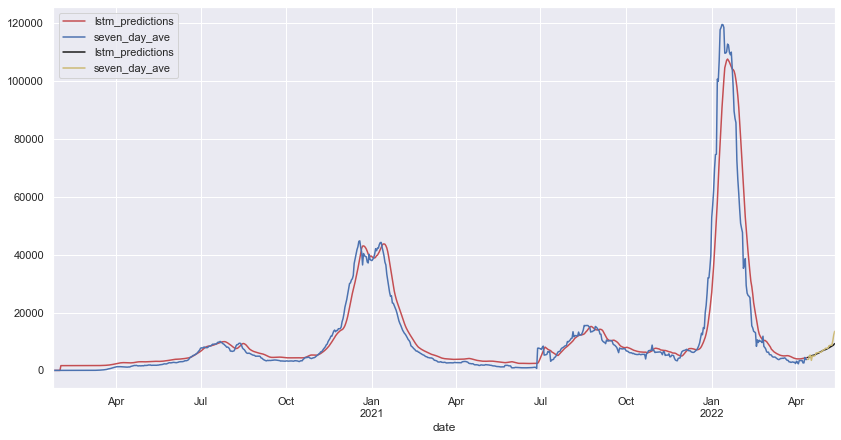

In [26]:
plt.figure(figsize=(14,7))
plot_predictions(df.loc[df.split=='train', 'seven_day_ave'], df.loc[df.split=='train', 'lstm_predictions'])
plot_predictions(df.loc[df.split=='test', 'seven_day_ave'], df.loc[df.split=='test', 'lstm_predictions'], c1='k', c2='y')
plt.show()

In [27]:
r2 = r2_score(df.loc[df.split=='test', 'seven_day_ave'], df.loc[df.split=='test', 'lstm_predictions'])
mape = mean_absolute_percentage_error(df.loc[df.split=='test', 'seven_day_ave'], df.loc[df.split=='test', 'lstm_predictions'])
mrse = np.sqrt(mean_squared_error(df.loc[df.split=='test', 'seven_day_ave'], df.loc[df.split=='test', 'lstm_predictions']))

print('Final model test results:\nMAPE: {}\nR-Squared: {}\nMRSE: {}'.format(mape, r2, mrse))

Final model test results:
MAPE: 0.0885050950995037
R-Squared: 0.7490582974198541
MRSE: 1126.7869455104212


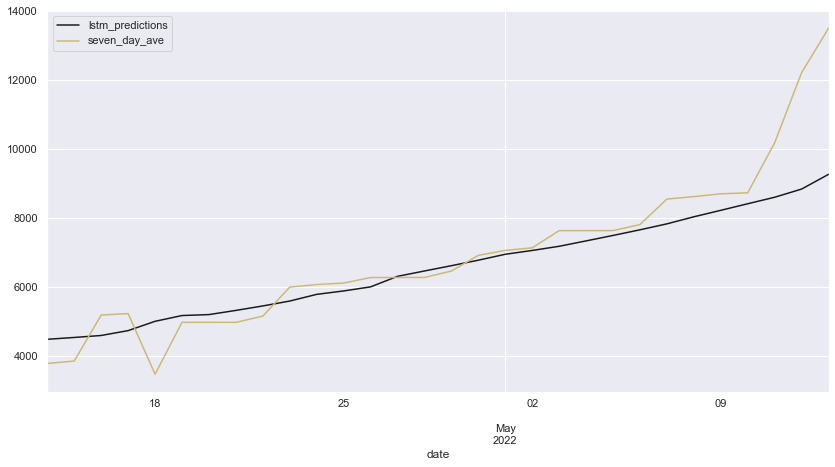

In [28]:
# Plot the test LSTM predictions against the ture values
plt.figure(figsize=(14,7))
plot_predictions(df.loc[df.split=='test', 'seven_day_ave'], df.loc[df.split=='test', 'lstm_predictions'], c1='k', c2='y')

The results of the LSTM are much better than that of the ARIMA model. All of the LSTM's metrics are better than those of the ARIMA models. One thing worth noting is that the LSTM predictions for the training set are not quite as accurate as those from the second ARIMA model, but its test predictions are significantly better. This shows that the LSTM model is better at generalizing the data. The goal for this time series was never to perfectly predict future covid values, rather the goal is to give a reliable generalization so that hospitals can prepare for changes in demand for beds.